# IDEA
-----------

We have seen that the data in outdated and mislabeled. Fitting a model to mislabeled and outdated data would not be appropriate to compare the model performance to human level. Here we employ a Bootstrapping mechanism to correct mislabels.

* We manually collect different variety of land and house images (1000 each) and make sure that the labels for collected images are consistent with the images.
* We start the regular bootstrap process.
    * We fit a model with these 2000 images and save the checkpoints to the disk.
    * We test the model on our large test corpus.
    * We place a rule based filtering criteria, such as, 
        * Find all misclassified images where the model prediction is 100% for 2 or more checkpoints 
        * Flag if the parcel was cropped based on bounding box.
        * And few other varying criteria.
        This is preferable because, let say that 2 checkpoints predicted an images with 100% house and we were able to flag it at a cropped region. Given the fact that 95% of images that were cropped based on building polygon were images of house. We can with a very good certainity say that the images is actually a house and was mislabeled as land.
    * Items that made it thought the filtering process are relabeled and the images are placed into the new labeled directories.
* Iterate: over and over

In [1]:
from __future__ import division, print_function, absolute_import
import logging
import time
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_intersecting_images_pin, DumpBatches
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


which_net = 'resnet'
batch_prepare = True
train = True
test = True

INPUT the RUN NAME: Options : ("A new run name" or "Any Previous Run Name"
 WHICH_RUN = mislabel_c
INPUT: Image-type OPTIONS: (assessor, assessor_code, aerial, overlayed, aerial_cropped, streetside and ensemble 
 IMAGE_TYPE = aerial_cropped


In [2]:
# from clean_directories import clean
# clean(dict(overlayed='summary,batch'),which_vendor='google', which_model='resnet')

## PREPARE/DUMP BATCHES:

In [2]:
start_time = time.time()

max_batches = None

if batch_prepare:
    start_time = time.time()
    
    cmn_land_pins, cmn_house_pins = get_intersecting_images_pin(is_assessor=False, is_aerial=True,
                                                                is_streetside=False, is_overlayed=True,
                                                                is_aerial_cropped=True, is_training=True)
    print(len(cmn_land_pins), len(cmn_house_pins))
    
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    params = dict(
            image_type='aerial_cropped',
            img_in_shape=[400, 400, 3],
            img_out_shape=[224, 224, 3],
            img_resize_shape=[128, 128, 3],
            img_crop_shape=[128, 128, 3],
            tr_batch_size = tr_batch_size,
            cv_batch_size = cv_batch_size,
            ts_batch_size = ts_batch_size,
            enable_rotation=True,
            shuffle_seed=881,
            get_stats=True,
            max_batches=max_batches)
    
    obj_cb = DumpBatches(params)
    obj_cb.dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins,is_training=True)

print ('--------------- %s seconds ------------------'%(time.time() - start_time))


5608 5608
--------------- 435.8829267024994 seconds ------------------


# TRAIN MODEL
------------

# VARIATION 2: Dropouts after every layer: Learning is pretty slow but improves gradually.
-----------------------

In [2]:
max_batches = 12
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=10, num_batches=max_batches, cv_num_batches=1, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to/from %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\new_test\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoint latest at:  C:\Users\newline\Documents\ImageClassification\data\checkpoints\new_test\aerial_cropped\resnet\resnet_epoch_19_batch_12
----------477.6754138469696 seconds------------


Mean Values: train_loss = 0.236546, train_acc = 0.933173, train_precision = 0.933479493511, train_recall = 0.934134615385, cv_loss = 0.442659990489, cv_acc = 0.885714274645, cv_precision = 0.902630561126, cv_recall = 0.866666666667


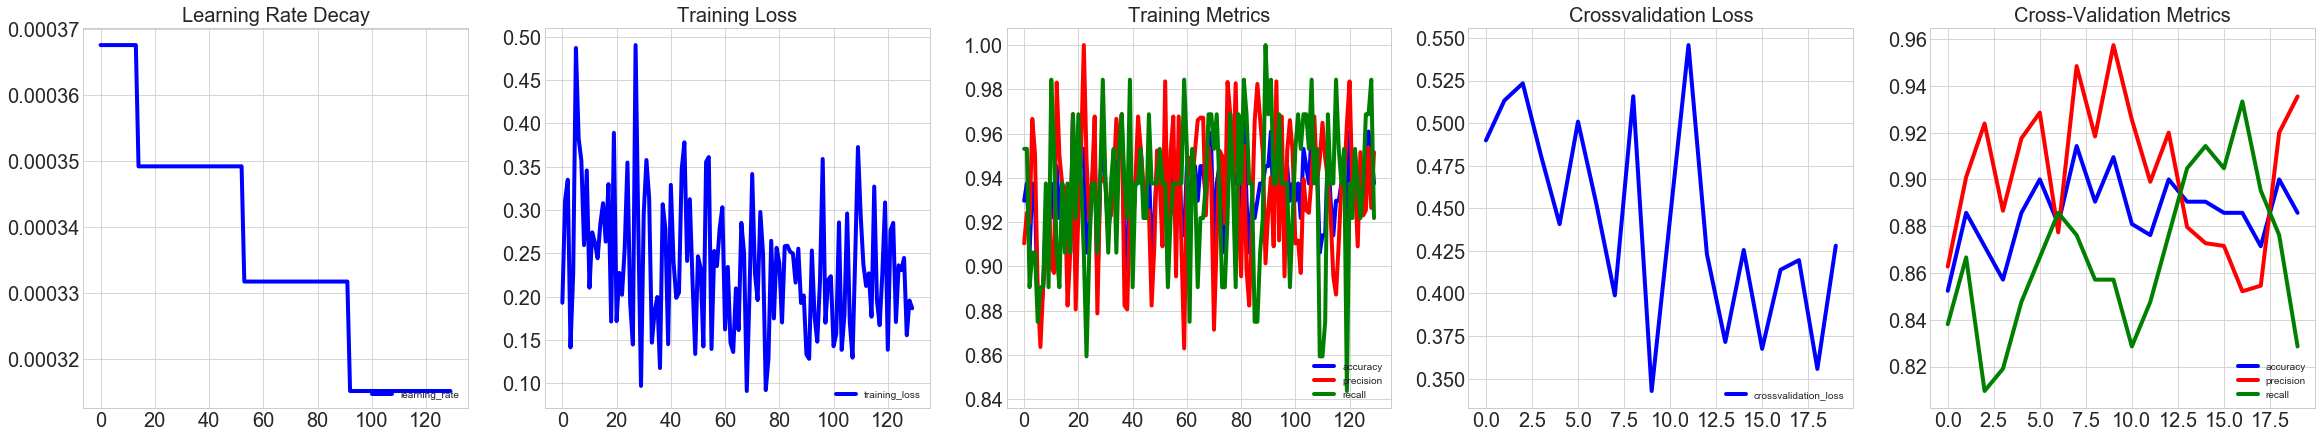

In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))
oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [4]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='new_test',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                which_data=which_data,
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data

In [5]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'cvalid_pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'cvalid_pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_7_batch_12,cvalid,0.602,0.881,0.955,0.800
1,epoch_8_batch_9,cvalid,0.552,0.867,0.914,0.810
2,epoch_8_batch_12,cvalid,0.466,0.881,0.908,0.848
3,epoch_9_batch_9,cvalid,0.377,0.910,0.948,0.867
4,epoch_9_batch_12,cvalid,0.424,0.900,0.957,0.838
5,epoch_17_batch_12,cvalid,0.329,0.914,0.948,0.876
6,epoch_18_batch_9,cvalid,0.458,0.895,0.956,0.829
7,epoch_18_batch_12,cvalid,0.442,0.900,0.957,0.838
8,epoch_19_batch_9,cvalid,0.442,0.924,0.959,0.886
9,epoch_19_batch_12,cvalid,0.411,0.929,0.959,0.895


# TEST
-------------------

# RESTART Notebook and point it to run mislabel_c
#### We Test on the Batches present in Mislabel_c

In [2]:
which_data = 'test'
checkpoint_name = "all"#"epoch_28_batch_9"
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='new_test',
                                use_checkpoint_for_imageType='aerial_cropped',
                                which_checkpoint=checkpoint_name,
                                optional_batch_name=None,
                                which_data=which_data,
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\mislabel_c\aerial_cropped, batch_names: ['batch_0', 'batch_1', 'batch_10', 'batch_11', 'batch_12', 'batch_13', 'batch_14', 'batch_15', 'batch_16', 'batch_17', 'batch_18', 'batch_19', 'batch_2', 'batch_20', 'batch_21', 'batch_22', 'batch_23', 'batch_24', 'batch_25', 'batch_26', 'batch_27', 'batch_28', 'batch_29', 'batch_3', 'batch_30', 'batch_31', 'batch_32', 'batch_33', 'batch_34', 'batch_35', 'batch_36', 'batch_37', 'batch_38', 'batch_39', 'batch_4', 'batch_40', 'batch_41', 'batch_42', 'batch_43', 'batch_44', 'batch_45', 'batch_46', 'batch_47', 'batch_48', 'batch_49', 'batch_5', 'batch_50', 'batch_51', 'batch_52', 'batch_53', 'batch_54', 'batch_55', 'batch_56', 'batch_57', 'batch_58', 'batch_59', 'batch_6', 'batch_60', 'batch_61', 'batch_62', 'batch_63', 'batch_64', 'batch_65', 'batch_66', 'batch_67', 'batch_68', 'batch_69', 'batch_7', 'batch_70', 'batch_71', '

In [3]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'test_pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'test_pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
print (prediction_metrics.shape)
prediction_metrics.head()

(87, 6)


,checkpoint,dataset_type,test_loss,test_acc,test_precsion,test_recall
0,epoch_28_batch_9,batch_0,0.607,0.906,0.906,0.906
1,epoch_28_batch_9,batch_1,0.566,0.906,0.894,0.922
2,epoch_28_batch_9,batch_10,0.927,0.906,0.933,0.875
3,epoch_28_batch_9,batch_11,1.185,0.914,0.896,0.938
4,epoch_28_batch_9,batch_12,0.619,0.914,0.896,0.938


In [4]:
print (prediction_outcomes.shape)
prediction_outcomes.tail()

(11216, 6)


,checkpoint,rownum,dataset_type,true_label,pred_label,pred_prob
11211,epoch_28_batch_9,123,batch_9,1.0,1,1.0
11212,epoch_28_batch_9,124,batch_9,1.0,1,1.0
11213,epoch_28_batch_9,125,batch_9,1.0,1,1.0
11214,epoch_28_batch_9,126,batch_9,1.0,1,1.0
11215,epoch_28_batch_9,127,batch_9,1.0,1,1.0


# MISLABEL STATISTICS

In [102]:
import os
import numpy as np
import pandas as pd
from config import pathDict


class GetMislabels():
    def __init__(self, which_data):
        self.which_data = which_data
        self.meta_stats_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'tr_cv_ts_pins_info.csv')
        self.input_img_path = pathDict['image_path']

        if which_data == 'cvalid':
            self.pred_stats_path = os.path.join(pathDict['statistics_path'], 'prediction_stats',
                                                'cvalid_pred_outcomes.csv')
        else:
            self.pred_stats_path = os.path.join(pathDict['statistics_path'], 'prediction_stats',
                                                'test_pred_outcomes.csv')
#         else:
#             raise ValueError('Provide proper data name: Option: cvalid, test')

    def concat_meta_n_pred_stats(self, pred_stats, meta_stats, checkpoint_name_arr, which_data):
        pred_meta_mrgd = pred_stats.merge(meta_stats, left_on=['rownum', "dataset_type"], right_on=['rownum', "dataset_type"], how='outer')
        if which_data:
            pred_meta_mrgd = pred_meta_mrgd[pred_meta_mrgd["dataset_type"] == which_data]
      
        column_names = ["property_pins", "property_type", "bbox_cropped", "true_label"]
        pred_prob_data = []
        for num, checkpoint_name in enumerate(checkpoint_name_arr):
            column_names += ['%s_pred_label' % (checkpoint_name), '%s_pred_prob' % (checkpoint_name)]
            if num == 0:
                pred_prob_data = np.array(
                    pred_meta_mrgd[pred_meta_mrgd["checkpoint"] == checkpoint_name][
                        ["property_pins", "property_type", "bbox_cropped", "true_label", "pred_label", "pred_prob"]
                    ]
                ).reshape(-1, 6)
            else:
                pred_prob_data = np.column_stack((
                    pred_prob_data,
                    np.array(
                        pred_meta_mrgd[pred_meta_mrgd["checkpoint"] == checkpoint_name][["pred_label", "pred_prob"]]).reshape(
                        -1, 2)
                ))
        pred_prob_data = pd.DataFrame(pred_prob_data, columns=column_names)
        float_columns = [col for col in column_names 
                         if col not in ['property_pins', 'property_type', 'bbox_cropped', 'true_label']]
       
        pred_prob_data['bbox_cropped'] = pred_prob_data['bbox_cropped'].astype('int')
        pred_prob_data['true_label'] = pred_prob_data['true_label'].astype('int')
        for cols in float_columns:
            pred_prob_data[cols] = pred_prob_data[cols].astype('float')

        if pred_prob_data.isnull().values.any():
            raise ValueError('NaN Found! Seems the concat operation did merge properly (Check dataframe shapes)')
        return pred_prob_data

    def dynamic_rule_based_mislabel_correction(self, min_pred_prob, checkpoint_arr, bbox_cropped=True):
        '''
            min_pred_prob: The minimum prediction values for each checkpoint to qualify as a mislabeled data.
            checkpoint_arr: checkpoints to use while dynamically finding classification error due to mislabeled data.

        '''
        if len(min_pred_prob) != len(checkpoint_arr):
            raise ValueError('Provide min_pred_prob for each Checkpoint')

        dynamic_query = ''
        for num, (prob, checkpoint_name) in enumerate(zip(min_pred_prob, checkpoint_arr)):
            q = ' %s_pred_prob >= %s & true_label-%s_pred_label!=0 &' % (
                checkpoint_name, prob, checkpoint_name)
            dynamic_query += q
        dynamic_query = dynamic_query.strip('&').strip(' ')

        if bbox_cropped:
            q = "((property_type=='land' & bbox_cropped==1) | (property_type=='house' & bbox_cropped==0))"
            dynamic_query += " & " + q
        return dynamic_query

    def get_pin_path(self, dataIN):
        land_data = np.array(dataIN[dataIN['property_type'] == 'land']['property_pins'])
        house_data = np.array(dataIN[dataIN['property_type'] == 'house']['property_pins'])

        land_mis_pins_path = [os.path.join(self.input_img_path, 'land', pins + '.jpg') for pins in land_data]
        house_mis_pins_path = [os.path.join(self.input_img_path, 'house', pins + '.jpg') for pins in house_data]

        print(len(land_mis_pins_path), len(house_mis_pins_path))
        return land_mis_pins_path, house_mis_pins_path

    def get_title_array(self, dataIN):
        land_data = dataIN[dataIN['property_type'] == 'land'].reset_index().drop('index', axis=1)
        house_data = dataIN[dataIN['property_type'] == 'house'].reset_index().drop('index', axis=1)

        land_data['rownum'] = pd.Series(range(0, len(land_data)))
        house_data['rownum'] = pd.Series(range(0, len(house_data)))

        land_title_arr = np.array(land_data["rownum"].astype(str) + '--' +
                                  land_data["property_pins"].astype(str))

        house_title_arr = np.array(house_data["rownum"].astype(str) + '--' +
                                   house_data["property_pins"].astype(str))

        print(len(land_title_arr), len(house_title_arr))
        return land_title_arr, house_title_arr

    def main(self, checkpoint_min_prob_dict, bbox_cropped=True):
        min_pred_prob = list(checkpoint_min_prob_dict.values())
        checkpoint_name_arr = list(checkpoint_min_prob_dict.keys())
        pred_stats = pd.read_csv(self.pred_stats_path)
        meta_stats = pd.read_csv(self.meta_stats_path, index_col=None)
        print (pred_stats.shape, meta_stats.shape)
        concat_meta_pred_data = self.concat_meta_n_pred_stats(pred_stats=pred_stats, meta_stats=meta_stats,
                                                              checkpoint_name_arr=checkpoint_name_arr,
                                                              which_data=self.which_data)
        dynamic_query = self.dynamic_rule_based_mislabel_correction(min_pred_prob=min_pred_prob,
                                                                    checkpoint_arr=checkpoint_name_arr,
                                                                    bbox_cropped=bbox_cropped)
        print (dynamic_query)
        mislabeled_data = concat_meta_pred_data.query(dynamic_query)
        land_mis_pins_path, house_mis_pins_path = self.get_pin_path(dataIN=mislabeled_data)
        land_title_arr, house_title_arr = self.get_title_array(dataIN=mislabeled_data)
        return mislabeled_data, land_mis_pins_path, house_mis_pins_path, land_title_arr, house_title_arr

In [103]:
min_pred_prob = 1
chkpnt_dict = {"epoch_28_batch_9":1}
bbox_cropped = True
mislabeled_data, land_mis_pins_path, house_mis_pins_path, land_title_arr, house_title_arr = GetMislabels(which_data=None).main(checkpoint_min_prob_dict = chkpnt_dict,
                                                                          bbox_cropped=bbox_cropped)

(11216, 6) (11216, 5)
epoch_28_batch_9_pred_prob >= 1 & true_label-epoch_28_batch_9_pred_label!=0 & ((property_type=='land' & bbox_cropped==1) | (property_type=='house' & bbox_cropped==0))
176 343
176 343


In [28]:
import numpy as np
import pandas as pd
import os
from scipy import misc
import matplotlib.pyplot as plt

from data_transformation.data_prep import process_images_given_path
# from viz_analysis.mislabels_correction import GetMislabels

%matplotlib inline

In [29]:
def vizualize(image_path_array, title_arr, data_type, rows, columns, figsize=(40, 6)):
    fig1, axs = plt.subplots(rows ,columns, figsize=figsize, facecolor='y', edgecolor='k')
    if columns> 1:
        axs = axs.ravel()
    for no, (image_path, title) in enumerate(zip(image_path_array, title_arr)):
        image, _ = process_images_given_path(image_path, img_in_shape=[400, 400, 3], img_out_shape=[224, 224, 3],
                                             img_crop_shape=[128, 128, 3], img_resize_shape=[128, 128, 3],
                                             enable_rotation=True, angle=90)
        axs[no].imshow(np.array(image, dtype=data_type))
        axs[no].set_title(title, fontsize=25)

(11376, 5) (1874, 4)


NameError: name 'cv_mislabeled_data' is not defined

In [26]:
chkpnt_arr = ["epoch_28_batch_9"]
bbox_cropped = False
(cv_mislabeled_data, cv_land_mis_pins_path, cv_house_mis_pins_path, cv_land_title_arr, 
 cv_house_title_arr) = GetMislabels(which_data='test').main(checkpoint_name_arr = chkpnt_arr, bbox_cropped=bbox_cropped)
cv_mislabeled_data.head()

(11376, 5) (1874, 4)


TypeError: 'NoneType' object is not iterable